In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('../data/rating_explicit_only.csv', sep=',', skipinitialspace=True)

n_users = df.learner_id.unique().shape[0]
n_items = df.movie_id.unique().shape[0]

print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))

Number of users = 78 | Number of movies = 405


In [3]:
id_max = df.sort_values(by=['learner_id'], ascending=False).head(n=1)

id_max = int(id_max.learner_id)

print('The maximum learner_id in this list is= ' + str(id_max))

The maximum learner_id in this list is= 111


In [4]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df,test_size=0.25)

train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)


In [5]:
# Create training and test matrix
R = np.zeros((id_max, n_items))
for line in train_data.itertuples():
    R[line[6]-1, line[5]-1] = line[2]  

T = np.zeros((id_max, n_items))
for line in test_data.itertuples():
    T[line[6]-1, line[5]-1] = line[2]

In [6]:
# Index matrix for training data
I = R.copy()
I[I > 0] = 1
I[I == 0] = 0

# Index matrix for test data
I2 = T.copy()
I2[I2 > 0] = 1
I2[I2 == 0] = 0

In [7]:
# Predict the unknown ratings through the dot product of the latent features for users and items 
def prediction(P,Q):
    return np.dot(P.T,Q)

In [22]:
lmbda = 0.9 # Regularisation weight
k = 8  # Dimensionality of the latent feature space
m, n = R.shape  # Number of users and items
n_epochs = 300  # Number of epochs
gamma=0.009 # Learning rate

P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix

In [23]:
# Calculate the RMSE
def rmse(I,R,Q,P):
    return np.sqrt(np.sum((I * (R - prediction(P,Q)))**2)/len(R[R > 0]))

In [24]:
#calculate MAE
def mae(I,R,Q,P):
    return np.sum(abs((I * (R - (np.dot(P.T,Q))))/len(R[R > 0])))

In [25]:
from sklearn.metrics import mean_absolute_error

train_errors = []
test_errors = []

#Only consider non-zero matrix 
users,items = R.nonzero()      
for epoch in range(n_epochs):
    error = 0
    for u, i in zip(users,items):
        e = R[u, i] - prediction(P[:,u],Q[:,i])  # Calculate error for gradient
        P[:,u] += gamma * ( e * Q[:,i] - lmbda * P[:,u]) # Update latent user feature matrix
        Q[:,i] += gamma * ( e * P[:,u] - lmbda * Q[:,i])  # Update latent movie feature matrix
        error += e
        #print(P)
#     print(abs(error/users.shape[0]))
#     train_rmse = rmse(I,R,Q,P) # Calculate root mean squared error from train dataset
#     test_rmse = rmse(I2,T,Q,P) # Calculate root mean squared error from test dataset
#     train_mae = mae(I,R,Q,P)
#     test_mae = mae(I2,T,Q,P)
    train_mae = mean_absolute_error(R, np.dot(P.T,Q))
    test_mae = mean_absolute_error(T, np.dot(P.T,Q))
    train_errors.append(train_mae)
    test_errors.append(test_mae)
    print("Epoch["+ str(epoch+1) + "/" + str(n_epochs) + "] Train error:" + str(train_mae) + "-->Test error:" + str(test_mae))

Epoch[1/300] Train error:8.10795036347-->Test error:8.14022990812
Epoch[2/300] Train error:7.46401685272-->Test error:7.49925986091
Epoch[3/300] Train error:7.14193410789-->Test error:7.17990651591
Epoch[4/300] Train error:6.90647097277-->Test error:6.94608661655
Epoch[5/300] Train error:6.7095113674-->Test error:6.75020106212
Epoch[6/300] Train error:6.5349353717-->Test error:6.57631258654
Epoch[7/300] Train error:6.3755130436-->Test error:6.41734915332
Epoch[8/300] Train error:6.22738270971-->Test error:6.2695331415
Epoch[9/300] Train error:6.08840242017-->Test error:6.13075216
Epoch[10/300] Train error:5.9572108347-->Test error:5.99969154489
Epoch[11/300] Train error:5.83289930211-->Test error:5.87544736656
Epoch[12/300] Train error:5.71480684912-->Test error:5.75736956901
Epoch[13/300] Train error:5.60242919587-->Test error:5.64497853112
Epoch[14/300] Train error:5.49538279339-->Test error:5.53789450968
Epoch[15/300] Train error:5.3933577436-->Test error:5.43581057791
Epoch[16/300]

Epoch[128/300] Train error:3.48312180166-->Test error:3.52009976306
Epoch[129/300] Train error:3.48276360306-->Test error:3.51973980961
Epoch[130/300] Train error:3.48242023342-->Test error:3.5193947412
Epoch[131/300] Train error:3.48209107563-->Test error:3.51906393825
Epoch[132/300] Train error:3.48177554024-->Test error:3.51874680899
Epoch[133/300] Train error:3.48147306417-->Test error:3.5184427881
Epoch[134/300] Train error:3.48118310936-->Test error:3.51815133541
Epoch[135/300] Train error:3.48090516156-->Test error:3.51787193467
Epoch[136/300] Train error:3.48063872921-->Test error:3.51760409241
Epoch[137/300] Train error:3.48038334231-->Test error:3.51734733681
Epoch[138/300] Train error:3.48013855585-->Test error:3.5171012167
Epoch[139/300] Train error:3.4799039503-->Test error:3.51686530055
Epoch[140/300] Train error:3.4796790986-->Test error:3.51663917552
Epoch[141/300] Train error:3.4794636073-->Test error:3.51642244663
Epoch[142/300] Train error:3.47925709987-->Test error:

Epoch[251/300] Train error:3.47543992266-->Test error:3.51234914077
Epoch[252/300] Train error:3.47545078607-->Test error:3.51235974767
Epoch[253/300] Train error:3.47546171034-->Test error:3.51237041685
Epoch[254/300] Train error:3.47547269042-->Test error:3.51238114323
Epoch[255/300] Train error:3.47548372145-->Test error:3.51239192195
Epoch[256/300] Train error:3.47549479875-->Test error:3.5124027483
Epoch[257/300] Train error:3.4755059178-->Test error:3.51241361777
Epoch[258/300] Train error:3.47551707426-->Test error:3.51242452601
Epoch[259/300] Train error:3.47552826396-->Test error:3.51243546885
Epoch[260/300] Train error:3.47553948289-->Test error:3.51244644224
Epoch[261/300] Train error:3.47555072719-->Test error:3.51245744233
Epoch[262/300] Train error:3.47556199312-->Test error:3.51246846538
Epoch[263/300] Train error:3.47557327713-->Test error:3.51247950782
Epoch[264/300] Train error:3.47558457578-->Test error:3.5124905662
Epoch[265/300] Train error:3.47559588576-->Test err

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(T, np.dot(P.T,Q))

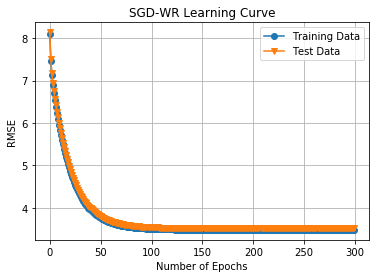

In [26]:
# Check performance by plotting train and test errors
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), test_errors, marker='v', label='Test Data');
plt.title('SGD-WR Learning Curve')
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Calculate prediction matrix R_hat (low-rank approximation for R)
R = pd.DataFrame(R)
R_hat=pd.DataFrame(prediction(P,Q))

In [ ]:
# Compare true ratings of user 17 with predictions
ratings = pd.DataFrame(data=R.loc[16,R.loc[16,:] > 0]).head(n=5)
ratings['Prediction'] = R_hat.loc[16,R.loc[16,:] > 0]
ratings.columns = ['Actual Rating', 'Predicted Rating']
ratings